In [1]:
import h5py
import numpy as np

# Load the HDF5 dataset
filename = 'reaction_diffusion_training_h4.h5'
with h5py.File(filename, 'r') as h5file:
    d1_values = h5file['d1'][:]
    beta_values = h5file['beta'][:]
    t_values = h5file['t'][:]
    x_values = h5file['x'][:]
    y_values = h5file['y'][:]
    u_data = h5file['u'][:]  # Shape: (num_samples, len(t), n, n)
    v_data = h5file['v'][:]  # Shape: (num_samples, len(t), n, n)

print(f"Loaded dataset with {u_data.shape[0]} samples.")

Loaded dataset with 50 samples.


In [2]:
# Reshape data into 2D matrix (num_samples * time_steps, grid_points)
num_samples, time_steps, n, _ = u_data.shape
grid_points = n * n
u_snapshots = u_data[:num_samples,:].reshape(num_samples * time_steps, grid_points).T
# v_snapshots = v_data[:num_samples,:].reshape(num_samples * time_steps, grid_points).T

# Combine u and v data (optional: POD on combined fields)
# combined_snapshots = np.vstack([u_snapshots, v_snapshots])  # Shape: (2 * grid_points, num_snapshots)

In [3]:
from sklearn.utils.extmath import randomized_svd

# Randomized SVD
n_components = 100  # Number of dominant modes to compute
U, Sigma, VT = randomized_svd(u_snapshots[:,::3], n_components=n_components, random_state=42)

print(f"Computed {U.shape[1]} approximate POD modes using randomized SVD.")

# Extract POD modes and singular values
POD_modes = U  # Each column is a POD mode
singular_values = Sigma  # Singular values
time_coefficients = VT.T  # Time-dependent coefficients

print(f"Computed {POD_modes.shape[1]} POD modes.")

Computed 100 approximate POD modes using randomized SVD.
Computed 100 POD modes.


In [4]:
# Load the HDF5 dataset
filename = 'reaction_diffusion_testing_h4.h5'

with h5py.File(filename, 'r') as h5file:
    d1_values_test   = h5file['d1'][:]
    beta_values_test = h5file['beta'][:]
    t_values_test    = h5file['t'][:]
    x_values_test    = h5file['x'][:]
    y_values_test    = h5file['y'][:]
    u_data_test      = h5file['u'][:]  # Shape: (num_samples, len(t), n, n)
    v_data_test      = h5file['v'][:]  # Shape: (num_samples, len(t), n, n)

print(f"Loaded dataset with {u_data_test.shape[0]} samples.")



Loaded dataset with 50 samples.


In [5]:
print(u_data[1,:])
print(u_data_test[1,:])

[[[-0.70358468 -0.94819076 -0.99147681 ...  0.35599826 -0.00248165
   -0.37815106]
  [-0.9257439  -0.99563051 -0.84602579 ...  0.76726494  0.4735983
    0.09338038]
  [-0.99999692 -0.88074097 -0.55917987 ...  0.98072547  0.82904637
    0.53314198]
  ...
  [-0.53975438 -0.85062899 -0.99249211 ... -0.2864191   0.19539078
    0.64133027]
  [-0.13028327 -0.53314198 -0.82904637 ...  0.12230865  0.55917987
    0.88074097]
  [ 0.31770155 -0.09338038 -0.4735983  ...  0.52576641  0.84602579
    0.99563051]]

 [[-0.5050129  -0.73951686 -0.91726497 ...  0.27004738 -0.05390732
   -0.34969644]
  [-0.80902608 -0.97360864 -0.94049258 ...  0.54057218  0.19075
   -0.2120628 ]
  [-0.86980814 -0.96283884 -0.72989035 ...  0.87643687  0.65042023
    0.23348791]
  ...
  [-0.2315063  -0.67834035 -0.90532484 ... -0.03566993  0.44617851
    0.65255409]
  [ 0.20009027 -0.27063165 -0.62128278 ...  0.38319223  0.77127815
    0.8892464 ]
  [ 0.40262171 -0.00127433 -0.37699485 ...  0.63433302  0.83462228
    0.8279

In [6]:
print(U.shape)

(1024, 100)


In [7]:
print(u_snapshots.shape)

(1024, 5050)


In [8]:
# Reshape training data into a 2D matrix (num_samples * time_steps, grid_points)
num_samples_train, time_steps_train, n_train, _ = u_data.shape
grid_points_train = n_train * n_train

# Subsample training data
num_samples_to_use = 5

end_index = (num_samples_to_use * (time_steps_train))

snapshots_train = u_data[:num_samples_to_use,:].reshape(end_index, grid_points_train).T

# Compute time coefficients for training data
time_coefficients_train = U.T @ snapshots_train[:, :end_index]

# Reconstruct training snapshots
snapshots_reconstructed_train = U @ time_coefficients_train

# Calculate reconstruction error for training data
reconstruction_error_train = (
    np.linalg.norm(snapshots_train[:, :end_index] - snapshots_reconstructed_train)
    / np.linalg.norm(snapshots_train[:, :end_index])
)

print(f"Train Reconstruction Error: {reconstruction_error_train:.12f}")

# Reshape testing data into a 2D matrix (num_samples * time_steps, grid_points)
num_samples_test, time_steps_test, n_test, _ = u_data_test.shape
grid_points_test = n_test * n_test

# Subsample testing data
snapshots_test = u_data_test[:num_samples_to_use,:].reshape(end_index, grid_points_test).T

# Compute time coefficients for testing data
time_coefficients_test = U.T @ snapshots_test[:, :end_index]

# Reconstruct testing snapshots
snapshots_reconstructed_test = U @ time_coefficients_test

# Calculate reconstruction error for testing data
reconstruction_error_test = (
    np.linalg.norm(snapshots_test[:, :end_index] - snapshots_reconstructed_test)
    / np.linalg.norm(snapshots_test[:, :end_index])
)

print(f"Test Reconstruction Error: {reconstruction_error_test:.12f}")

Train Reconstruction Error: 0.001884277007
Test Reconstruction Error: 0.008825176548


In [9]:
print(Sigma)

[6.08055429e+02 6.01495552e+02 1.51968853e+02 1.50451162e+02
 1.08291455e+02 1.04043524e+02 4.84455795e+01 4.73476677e+01
 3.71018949e+01 3.24765490e+01 1.96065735e+01 1.89915766e+01
 1.81180340e+01 1.69762867e+01 1.53250680e+01 1.47879071e+01
 1.28447103e+01 1.13460060e+01 1.04595974e+01 9.93316206e+00
 9.21050989e+00 8.82161204e+00 8.50214932e+00 8.00806408e+00
 7.90182396e+00 7.54822321e+00 7.03045225e+00 6.89000053e+00
 6.20518029e+00 5.72780221e+00 5.19499265e+00 5.15194407e+00
 4.89598860e+00 4.72987909e+00 4.23481527e+00 4.16617224e+00
 4.00629198e+00 3.84305193e+00 3.72860847e+00 3.34017195e+00
 3.18576915e+00 3.16714446e+00 2.99766295e+00 2.73618395e+00
 2.52596344e+00 2.40585579e+00 2.34197629e+00 2.22765462e+00
 2.09130220e+00 2.05746109e+00 2.03993869e+00 1.95339961e+00
 1.78262586e+00 1.76030240e+00 1.64008241e+00 1.62174305e+00
 1.54090957e+00 1.48538942e+00 1.40560302e+00 1.33093199e+00
 1.28162923e+00 1.18383422e+00 1.14198246e+00 1.12479875e+00
 1.05534747e+00 1.028077

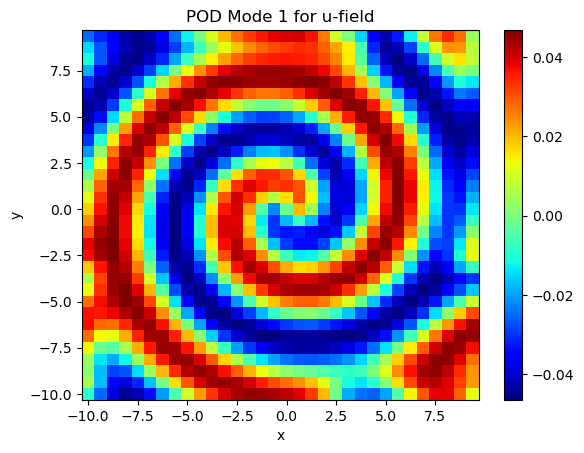

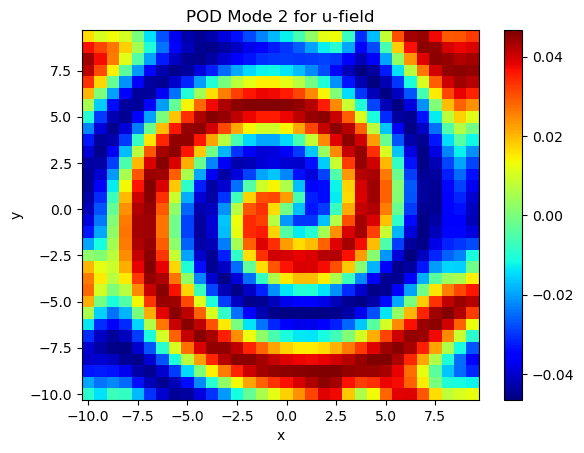

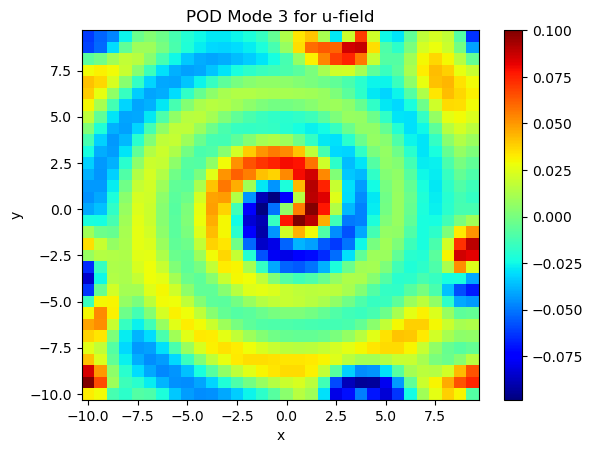

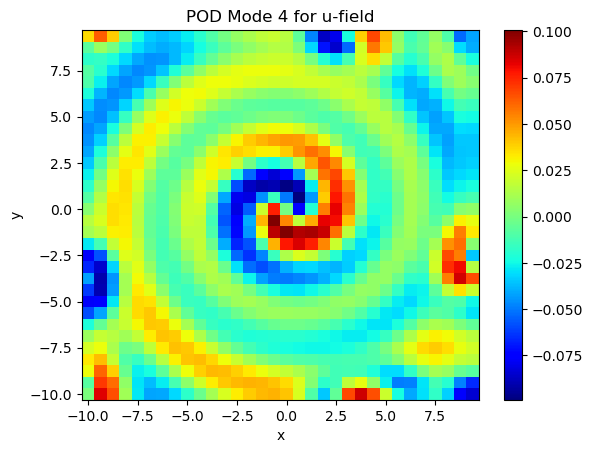

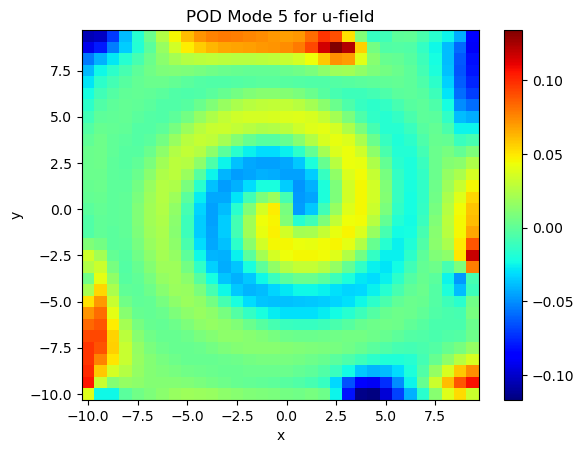

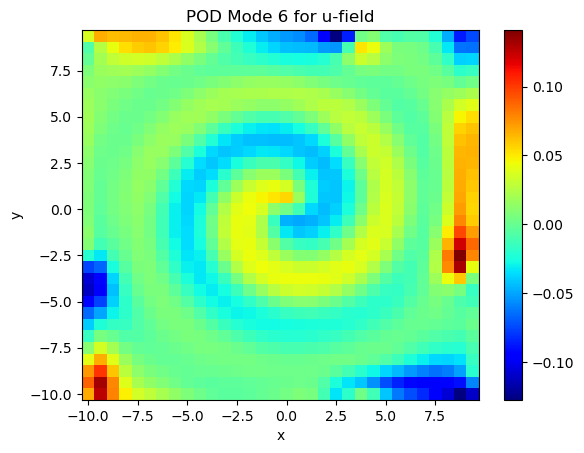

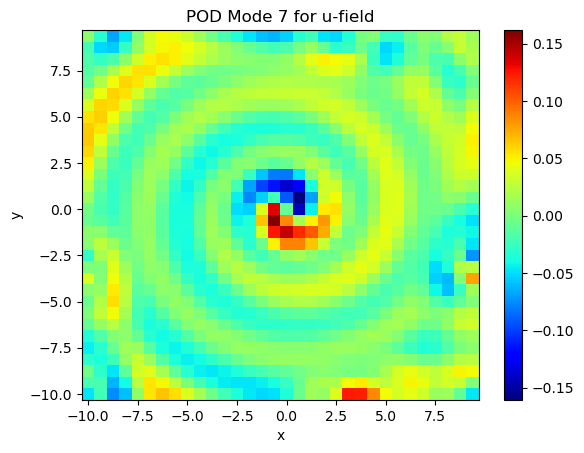

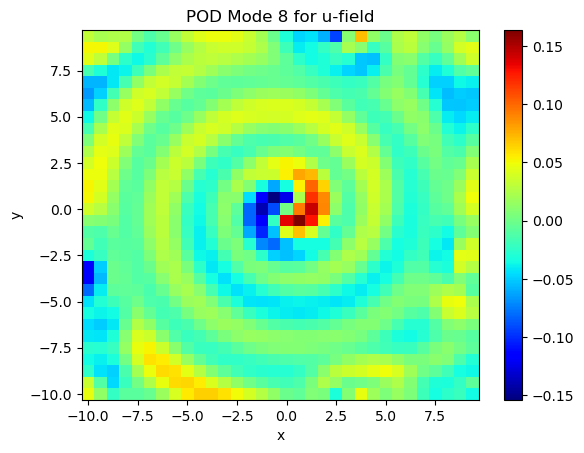

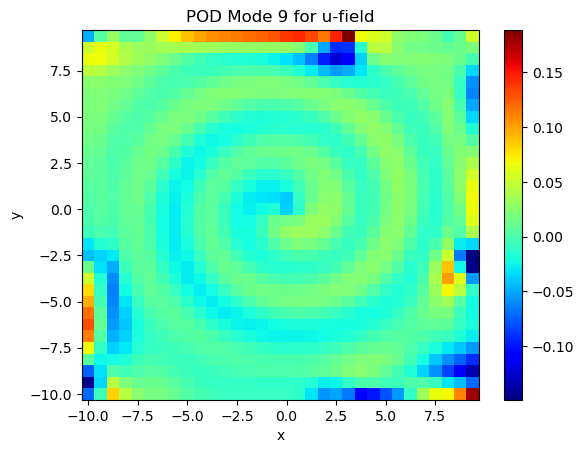

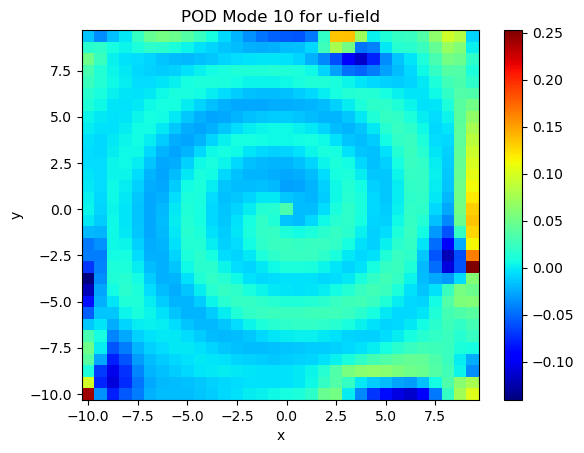

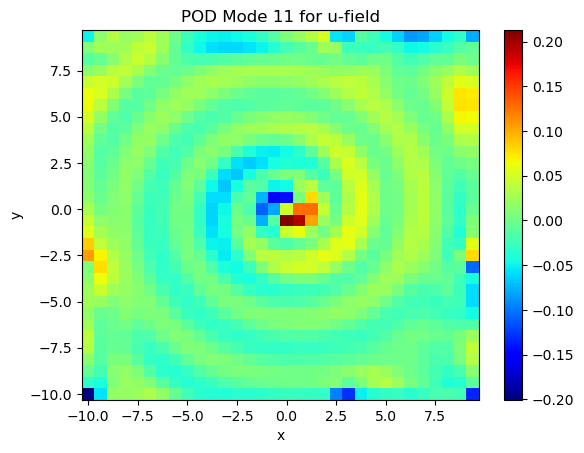

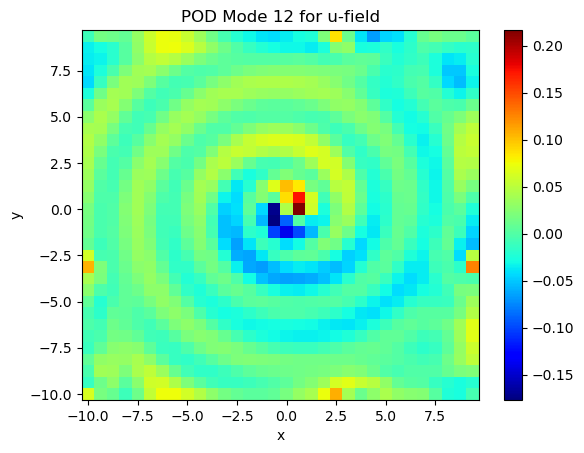

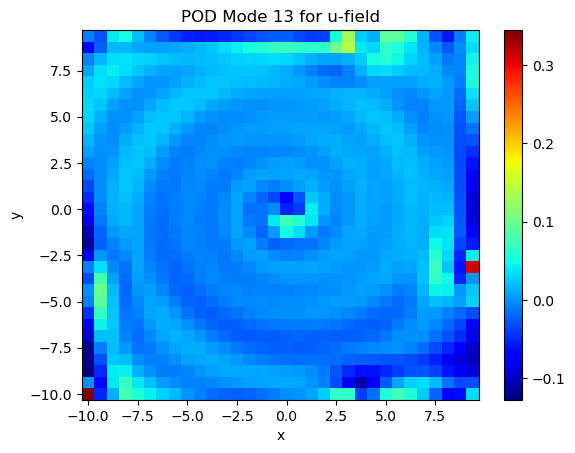

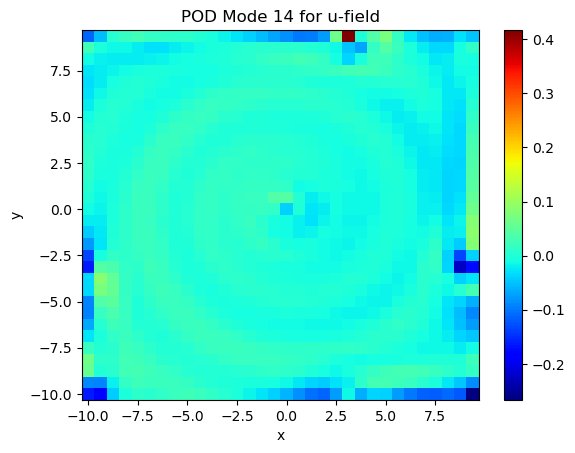

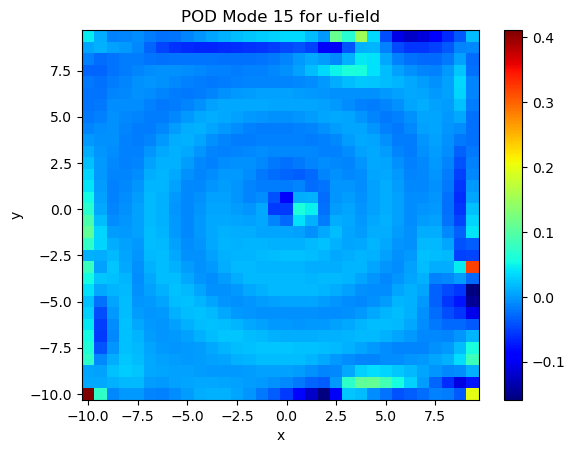

In [10]:
import matplotlib.pyplot as plt

# Reshape and visualize the first few POD modes for the u-field
num_modes_to_plot = 15
for i in range(num_modes_to_plot):
    mode = U[:grid_points, i].reshape((n, n))  # Extract mode for u-field
    plt.figure()
    plt.pcolormesh(x_values, y_values, mode, shading='auto', cmap='jet')
    plt.colorbar()
    plt.title(f"POD Mode {i+1} for u-field")
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

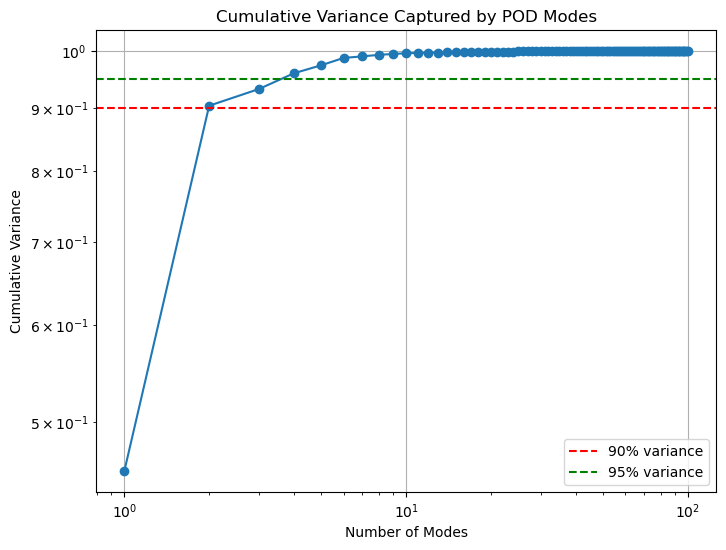

Number of modes to capture 90% variance: 2
Number of modes to capture 95% variance: 4
Number of modes to capture 99% variance: 7
Number of modes to capture 99.9% variance: 21


In [11]:
# Assuming 'Sigma' contains the singular values from SVD

# Compute the variance captured by each mode
variance_captured = Sigma**2 / np.sum(Sigma**2)

# Compute the cumulative variance
cumulative_variance = np.cumsum(variance_captured)

# Plot cumulative variance
plt.figure(figsize=(8, 6))
plt.loglog(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
plt.axhline(0.9, color='r', linestyle='--', label='90% variance')
plt.axhline(0.95, color='g', linestyle='--', label='95% variance')
plt.title('Cumulative Variance Captured by POD Modes')
plt.xlabel('Number of Modes')
plt.ylabel('Cumulative Variance')
plt.grid(True)
plt.legend()
plt.show()

# Optionally print the number of modes needed for 90% and 95% variance
n_modes_90 = np.searchsorted(cumulative_variance, 0.9) + 1
n_modes_95 = np.searchsorted(cumulative_variance, 0.95) + 1
n_modes_99 = np.searchsorted(cumulative_variance, 0.99) + 1
n_modes_999 = np.searchsorted(cumulative_variance, 0.999) + 1
print(f"Number of modes to capture 90% variance: {n_modes_90}")
print(f"Number of modes to capture 95% variance: {n_modes_95}")
print(f"Number of modes to capture 99% variance: {n_modes_99}")
print(f"Number of modes to capture 99.9% variance: {n_modes_999}")

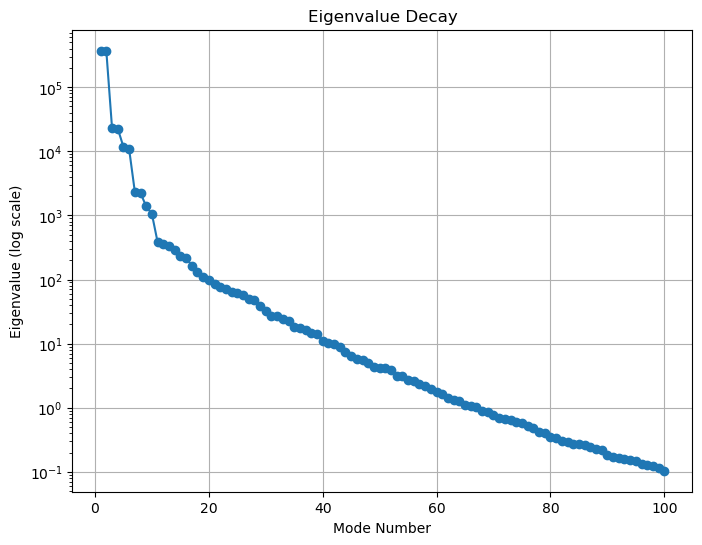

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'Sigma' contains the singular values from SVD

# Compute the eigenvalues (square of singular values)
eigenvalues = Sigma**2

# Plot eigenvalue decay
plt.figure(figsize=(8, 6))
plt.semilogy(range(1, len(eigenvalues) + 1), eigenvalues, marker='o', linestyle='-')
plt.title('Eigenvalue Decay')
plt.xlabel('Mode Number')
plt.ylabel('Eigenvalue (log scale)')
plt.grid(True)
plt.show()

In [13]:
import pandas as pd

# Assume:
# - 'd1_values' and 'beta_values' are arrays of parameters.
# - 't_values' is the array of time steps.
# - 'time_coefficients' is from SVD (shape: snapshots x modes).
# - 'num_samples', 'time_steps' are defined.



# Reshape d1 and beta to align with snapshots
d1_repeated = np.repeat(d1_values[:num_samples], time_steps)  # Repeat for all time steps
beta_repeated = np.repeat(beta_values[:num_samples], time_steps)  # Repeat for all time steps

# Tile the time array to align with snapshots
time_repeated = np.tile(t_values, num_samples)  # Tile for all samples

# Combine all inputs
inputs = np.vstack([d1_repeated, beta_repeated, time_repeated]).T  # Shape: (snapshots, 3)

# Combine inputs with coefficients (targets)
dataset = np.hstack([inputs])  # Shape: (snapshots, 3 + num_modes)

# Convert to DataFrame for easy manipulation
columns = ['d1', 'beta', 'time']
df = pd.DataFrame(dataset, columns=columns)

# Export to CSV
df.to_csv('pod_coefficients_dataset_usnapshots_32x32_coarse.csv', index=False)
print("Dataset exported to 'pod_coefficients_dataset.csv'.")

# Alternatively, save as HDF5


Dataset exported to 'pod_coefficients_dataset.csv'.


In [14]:
num_samples

50

In [15]:
d1_repeated = np.repeat(d1_values_test[:num_samples], time_steps)  # Repeat for all time steps
beta_repeated = np.repeat(beta_values_test[:num_samples], time_steps)  # Repeat for all time steps

# Tile the time array to align with snapshots
time_repeated = np.tile(t_values, num_samples)  # Tile for all samples

# Combine all inputs
inputs = np.vstack([d1_repeated, beta_repeated, time_repeated]).T  # Shape: (snapshots, 3)

# Combine inputs with coefficients (targets)
dataset = np.hstack([inputs])  # Shape: (snapshots, 3 + num_modes)

# Convert to DataFrame for easy manipulation
columns = ['d1', 'beta', 'time']
df = pd.DataFrame(dataset, columns=columns)

# Export to CSV
df.to_csv('pod_coefficients_testing_dataset_usnapshots_32x32_coarse.csv', index=False)
print("Dataset exported to 'pod_coefficients_dataset.csv'.")

with h5py.File('pod_coefficients_testing_dataset_32x32_coarse.h5', 'w') as h5file:
    h5file.create_dataset('inputs', data=inputs)  # Parameters + time
    h5file.create_dataset('coefficients', data=time_coefficients)  # POD coefficients
print("Dataset exported to 'pod_coefficients_dataset.h5'.")

Dataset exported to 'pod_coefficients_dataset.csv'.
Dataset exported to 'pod_coefficients_dataset.h5'.


In [16]:
x_values.shape

(32,)

In [17]:
# Export the basis to an HDF5 file
with h5py.File('pod_basis_32x32_coarse.h5', 'w') as h5file:
    # Save POD modes (spatial basis)
    h5file.create_dataset('POD_modes', data=POD_modes)  # Shape: (grid_points, num_modes)
    
    # Save singular values
    h5file.create_dataset('singular_values', data=Sigma)  # Shape: (num_modes,)
    
    # Save spatial grid
    h5file.create_dataset('x', data=x_values)  # Shape: (n,)
    h5file.create_dataset('y', data=y_values)  # Shape: (n,)
    
    # Save metadata
    h5file.attrs['grid_size'] = len(x_values)  # Number of grid points along one dimension
    h5file.attrs['num_modes'] = POD_modes.shape[1]  # Number of modes saved

print("POD basis exported to 'pod_basis.h5'.")

POD basis exported to 'pod_basis.h5'.
